# Optogenetic stimulation

How to inject an optogenetic intervention (opsin and optic fiber) into a simulation.

Preamble:

In [1]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import matplotlib.pyplot as plt

from cleosim import *

# numpy faster than cython for lightweight example
prefs.codegen.target = 'numpy'
# for reproducibility
np.random.seed(1866)

## Create the Brian network model
We'll use a small neuron group, biased by Poisson input spikes. Note that the opsin model is conductance-based and so depends on somewhat realistic membrane voltages. Quadratic or exponential integrate-and-fire maintain simplicity while modeling the upward membrane potential spike and should be suitable for our purposes. We'll use the exponential flavor. More info, see the [related section in the Neuronal Dynamics online textbook](https://neuronaldynamics.epfl.ch/online/Ch5.S2.html).

In [2]:
n = 10
ng = NeuronGroup(
    n,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) - Rm*I) / tau_m : volt
    I : amp
    """,
    threshold="v>30*mV",
    reset="v=-55*mV",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70*mV,
    },
)
ng.v = -70 * mV

input_group = PoissonInput(ng, "v", n, 100 * Hz, 1 * mV)

mon = SpikeMonitor(ng)

net = Network(ng, input_group, mon)

## Assign coordinates and configure optogenetic model
The `OptogeneticIntervention` class implements the chosen opsin kinetics model with specified parameters. A standard four-state Markov model as well as channel-rhodopsin 2 (ChR2) parameters are included with cleosim and are accessible in the `cleosim.opto` module. For extending to other models (such as three-state or six-state), see the [source code](https://github.com/kjohnsen/cleosim/blob/master/cleosim/opto.py)&mdash;the state equations, opsin-specific parameters, and light wavelength-specific parameters (if not using 473-nm blue) would be needed.

For reference, cleosim draws heavily on [Foutz et al., 2012](https://journals.physiology.org/doi/full/10.1152/jn.00501.2011) for the light propagation model and on [Evans et al., 2016](https://www.frontiersin.org/articles/10.3389/fninf.2016.00008/full) for the opsin kinetics model.

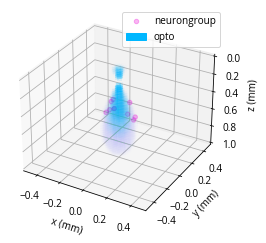

In [3]:
from cleosim.coordinates import assign_coords_rand_rect_prism, plot_neuron_positions

assign_coords_rand_rect_prism(ng, xlim=(-0.1, 0.1), ylim=(-0.1, 0.1), zlim=(0.4, 0.6))

from cleosim.opto import *

opto = OptogeneticIntervention(
    name="opto",
    opsin_model=four_state,
    opsin_params=ChR2_four_state,
    light_model_params=default_blue,
    location=(0, 0, 0.5) * mm,
)

plot_neuron_positions(
    ng,
    colors=["xkcd:fuchsia"],
    xlim=(-0.5, 0.5),
    ylim=(-0.5, 0.5),
    zlim=(0, 1),
    devices_to_plot=[opto],
)

## Open-loop optogenetic stimulation
We need to inject our optogenetic intervention into the simulator. `cleosim` handles all the object creation and equations needed to interact with the existing Brian model without the need to alter it, with the possible exception of adding a variable to represent the opsin current. This needs to be specified upon injection with `Iopto_var_name=...` if not the default `Iopto`. The membrane potential variable name also needs to be specified (with `v_var_name=...`) if not the default `v`.

In [4]:
sim = CLSimulator(net)
sim.inject_stimulator(opto, ng, Iopto_var_name='I')

### IO processor setup

Here we design an IO processor that ignores measurements and simply sets the light intensity according to the `stimulus(t)` function:

In [5]:
from cleosim.processing import LatencyIOProcessor

def stimulus(time_ms):
    f = 30
    return 1 * (1 + np.sin(2*np.pi*f * time_ms/1000))

class OpenLoopOpto(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sampling_period_ms=1)

    # since this is open-loop, we don't use state_dict
    def compute_ctrl_signal(self, state_dict, time_ms):
        opto_intensity = stimulus(time_ms)
        # return output dict and time
        return ({"opto": opto_intensity}, time_ms)

sim.set_io_processor(OpenLoopOpto())

### Run simulation and plot results

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


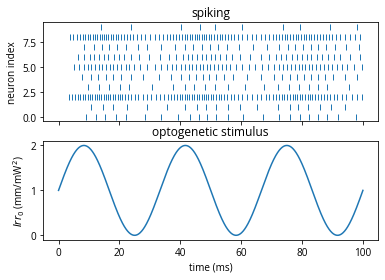

In [6]:
sim.run(100*ms)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(mon.t / ms, mon.i, '|')
ax1.set(ylabel='neuron index', title='spiking')
t_sim=np.linspace(0, 100, 1000)
ax2.plot(t_sim, stimulus(t_sim))
ax2.set(ylabel=r'$Irr_0$ (mm/mW$^2$)', title='optogenetic stimulus', xlabel='time (ms)');

We can see clearly that firing rate correlates with light intensity as expected.

As a recap, in this tutorial we've seen how to:
* configure an `OptogeneticIntervention`,
* inject it into the simulation,
* and control its light intensity in an open-loop fashion.